In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import screenpro as scp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from matplotlib import font_manager as fm

from matplotlib import rcParams, rc_context

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

https://stackoverflow.com/a/60390860/9609769

https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html

In [3]:
from screenpro.load import loadScreenProcessingData, read_adata_pkl

In [4]:
from plotnine import *

In [204]:
def plot_ggplot_pca(adata,fill,legend_position= 'top',figure_size= (4.5, 5)):
    pca = pd.concat([
        pd.DataFrame(
            adata.obsm['X_pca'][:,[0,1]],
            index=adata.obs.index,
            columns=['PC-1','PC-2']
        ),
        adata.obs.drop('replicate',axis=1)
    ],axis=1)
    
    pca_p =  (ggplot(pca) 
     + geom_point(aes(
         x = 'PC-1',
         y = 'PC-2',
         fill=fill, 
         # shape = shape
     ), color='black', size = 8)
     + geom_text(aes(
         x = 'PC-1',
         y = 'PC-2',
         label = fill,
         size = 3
     ),
         nudge_y = 3,
         nudge_x = 7,
                )
     + theme_classic()
     + theme(
         panel_grid_major   = element_blank(), 
         panel_grid_minor   = element_blank(), 
         panel_background   = element_blank(), 

         # legend_background  = element_blank(), 
         legend_position    = legend_position,
         # legend_direction   = 'horizontal', # affected by the ncol=2
         # legend_text_legend = element_text(size=8),

         axis_line          = element_line(size=2),
         axis_text_x        = element_text(size=8),
         axis_text_y        = element_text(size=8),
         axis_title_x       = element_text(weight='bold', size=12),
         axis_title_y       = element_text(weight='bold', size=12),

         text               = element_text(font = 'arial'),

         figure_size        = figure_size
     )
     # + xlim(-60,80)
     # + ylim(-30,60)
     # + scale_color_discrete(guide=False)
    )

    return pca_p

### Get phenotype scores

In [6]:
Ci = read_adata_pkl('datasets/CRISPRi')
Ca_A549 = read_adata_pkl('datasets/CRISPRa_A549')
Ca_k562 = read_adata_pkl('datasets/CRISPRa_k562')

In [7]:
Ci.comparisons

{'gamma': 'gamma',
 'PARPi': 'rho1',
 'DNAPKi': 'rho2',
 'ATMi': 'rho3',
 'ATRi': 'rho4',
 'WEE1i': 'rho5',
 'PARPi+DNAPKi': 'rho6',
 'PARPi+ATMi': 'rho7',
 'PARPi+ATRi': 'rho8',
 'PARPi+WEE1i': 'rho9'}

### sgRNA level phenotypes

In [125]:
def get_pdata(screen,filter_zero=True):
    pdata = ad.AnnData(
        X = screen.phenotypes['phenotypes'].T,
        var = screen.adata.obs
    )
    
    for k,v in screen.comparisons.items():
        pdata.obs.index = pdata.obs.index.str.replace(v,k)
    
    if filter_zero:
        pdata = pdata[:,pdata.to_df().isna().sum(axis=0).eq(0)]
    
    pdata.obs = pd.DataFrame(list(pdata.obs.index.str.split(' ')), columns = ['score','replicate'],index=pdata.obs.index,dtype=str)
    
    return pdata

### CRISPRi

In [129]:
Ci_pdata = get_pdata(Ci)

Ci_pdata.obs.score = pd.Categorical(
    Ci_pdata.obs.score,
    categories=['gamma',
                'PARPi',
                'DNAPKi',
                'PARPi+DNAPKi',
                'ATMi',
                'PARPi+ATMi',
                'ATRi',
                'PARPi+ATRi',
                'WEE1i',
                'PARPi+WEE1i'
               ]
)


Ci_pdata.obs['treatment'] = 'ctrl'
Ci_pdata.obs.loc[Ci_pdata.obs.score.str.contains('i'),'treatment'] = 'mono'
Ci_pdata.obs.loc[Ci_pdata.obs.score.str.contains('i\+'),'treatment'] = 'combo'
Ci_pdata.obs['treatment'] = pd.Categorical(Ci_pdata.obs['treatment'],categories=['ctrl','mono','combo'])

___
only keep `ave` scores:

In [9]:
Ci_pdata_ave = Ci_pdata[Ci_pdata.obs.index.str.contains('ave'),].copy()

In [10]:
Ci_pdata_ave

AnnData object with n_obs × n_vars = 10 × 97228
    obs: 'score', 'replicate', 'treatment'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'

___

In [11]:
Ci_pdata_reps = Ci_pdata[~Ci_pdata.obs.index.str.contains('ave'),].copy()

In [130]:
Ci_pdata_reps

AnnData object with n_obs × n_vars = 20 × 97228
    obs: 'score', 'replicate', 'treatment'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'

#### PCA – mono

In [14]:
Ci_pdata_mono = Ci_pdata[
    (~Ci_pdata.obs.index.str.contains('ave')) & (Ci_pdata.obs.treatment.eq('mono')),
].copy()

In [15]:
Ci_pdata_mono.obs

,score,replicate,treatment
PARPi rep1,PARPi,rep1,mono
PARPi rep2,PARPi,rep2,mono
DNAPKi rep1,DNAPKi,rep1,mono
DNAPKi rep2,DNAPKi,rep2,mono
ATMi rep1,ATMi,rep1,mono
ATMi rep2,ATMi,rep2,mono
ATRi rep1,ATRi,rep1,mono
ATRi rep2,ATRi,rep2,mono
WEE1i rep1,WEE1i,rep1,mono
WEE1i rep2,WEE1i,rep2,mono


In [ ]:
sc.pp.regress_out(Ci_pdata_mono,'replicate')

it takes so long :)

In [ ]:
sc.tl.pca(Ci_pdata_mono, svd_solver='arpack')

In [ ]:
sc.pl.pca_variance_ratio(Ci_pdata_mono, log=True, n_pcs=5) # scanpy generates the filename automatically

In [ ]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_mono,
        size=300,
        color=['treatment'],
    )  # plot the pca results with color as mouse.id 
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_mono,
        size=300,
        color=['score'],
    )  # plot the pca results with color as mouse.id 

In [ ]:
pca_mono = plot_ggplot_pca(Ci_pdata_mono)

In [ ]:
pca_mono.save('PCA_mono_ggplot.pdf')

#### PCA (1)

In [18]:
sc.pp.regress_out(Ci_pdata_reps,'replicate')

In [19]:
sc.tl.pca(Ci_pdata_reps, svd_solver='arpack')

In [26]:
# sc.pl.pca_variance_ratio(Ci_pdata_reps, log=True, n_pcs=5) # scanpy generates the filename automatically

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


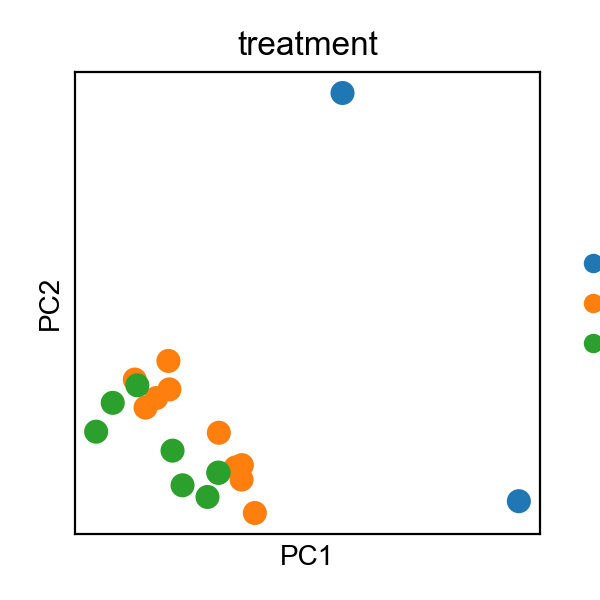

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


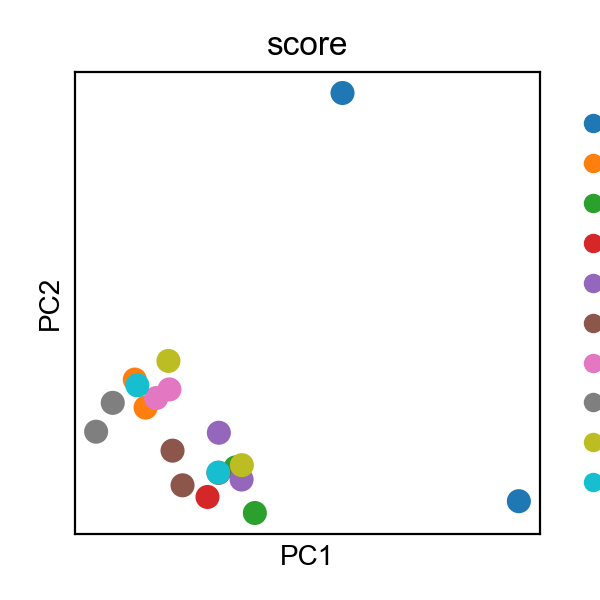

In [25]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_reps,
        size=300,
        color=['treatment'],
    )  # plot the pca results with color as mouse.id 
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_reps,
        size=300,
        color=['score'],
    )  # plot the pca results with color as mouse.id 

In [64]:
pca_reps = plot_ggplot_pca(Ci_pdata_reps,fill='treatment')

In [65]:
pca_reps.save('figures/PCA_reps_ggplot.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 5 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_reps_ggplot.pdf


#### PCA (2)

let's skip `gamma` and redo the PCA

In [22]:
Ci_pdata_reps_rho = Ci_pdata_reps[~Ci_pdata_reps.obs.score.eq('gamma'),:].copy()

In [23]:
sc.pp.regress_out(Ci_pdata_reps_rho,'replicate')

In [24]:
sc.tl.pca(Ci_pdata_reps_rho, svd_solver='arpack')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


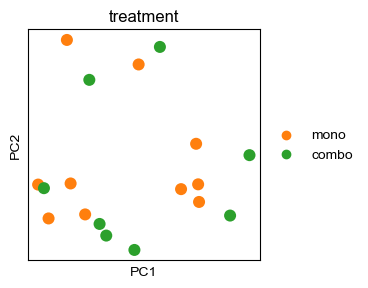

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


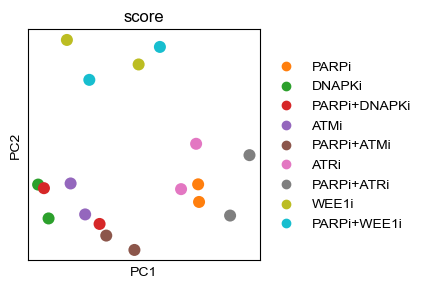

In [26]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_reps_rho,
        size=300,
        color=['treatment'],
    )  # plot the pca results with color as mouse.id 
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_reps_rho,
        size=300,
        color=['score'],
    )  # plot the pca results with color as mouse.id 

In [27]:
pca_all = plot_ggplot_pca(Ci_pdata_reps_rho)

In [29]:
pca_all.save('PCA_all_ggplot.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 5 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_all_ggplot.pdf


___

In [25]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize = (8, 3))

# sc.pl.pca(
#     Ci_pdata_reps_rho,
#     size=300,
#     # color=['treatment'],
#     show=False,
#     ax=ax1
# ) 

# sc.pl.pca(
#     Ci_pdata_reps_rho,
#     size=300,
#     color=['score'],
#     title = 'rho scores',
#     show=False,
#     ax=ax2
# )  

# plt.tight_layout()
# plt.savefig('PCA_plots.pdf')
# plt.show()

#### PCA (3)

In [47]:
pca = pd.concat([
    pd.DataFrame(
        Ci_pdata_reps_rho.obsm['X_pca'][:,[0,1]],
        index=Ci_pdata_reps_rho.obs.index,
        columns=['PC-1','PC-2']
    ),
    Ci_pdata_reps_rho.obs.drop('replicate',axis=1)
],axis=1)

In [48]:
pca

,PC-1,PC-2,score
PARPi rep1,42.012466,-12.790860,PARPi
PARPi rep2,35.160873,-7.829471,PARPi
DNAPKi rep1,-48.038116,-5.300872,DNAPKi
DNAPKi rep2,-49.015438,-21.487181,DNAPKi
ATMi rep1,-29.788280,-4.858507,ATMi
ATMi rep2,-28.606756,-20.052711,ATMi
ATRi rep1,31.518496,-8.258300,ATRi
ATRi rep2,33.939518,8.076000,ATRi
WEE1i rep1,8.669685,42.400562,WEE1i
WEE1i rep2,-38.483906,49.338211,WEE1i


In [49]:
from plotnine import *

In [52]:
pca_p =  (ggplot(pca) 
 + geom_point(aes(
     x = 'PC-1',
     y = 'PC-2',
     fill='score', 
     # shape = 'treatment'
 ), color='black', size = 8)
 + geom_text(aes(
     x = 'PC-1',
     y = 'PC-2',
     label = 'score',
     size = 3
 ),
     nudge_y = 3,
     nudge_x = 7,
            )
 + theme_classic()
 + theme(
     panel_grid_major   = element_blank(), 
     panel_grid_minor   = element_blank(), 
     panel_background   = element_blank(), 
     
     legend_background  = element_blank(), 
     legend_position    = 'top',
     legend_direction   = 'horizontal', # affected by the ncol=2
     legend_text_legend = element_text(size=8),
     
     axis_line          = element_line(size=2),
     axis_text_x        = element_text(size=8),
     axis_text_y        = element_text(size=8),
     axis_title_x       = element_text(weight='bold', size=12),
     axis_title_y       = element_text(weight='bold', size=12),
     
     text               = element_text(font = 'arial'),

     figure_size        = (4.5, 5)
 )
 + xlim(-60,80)
 # + ylim(-30,60)
          # + scale_color_discrete(guide=False)

)

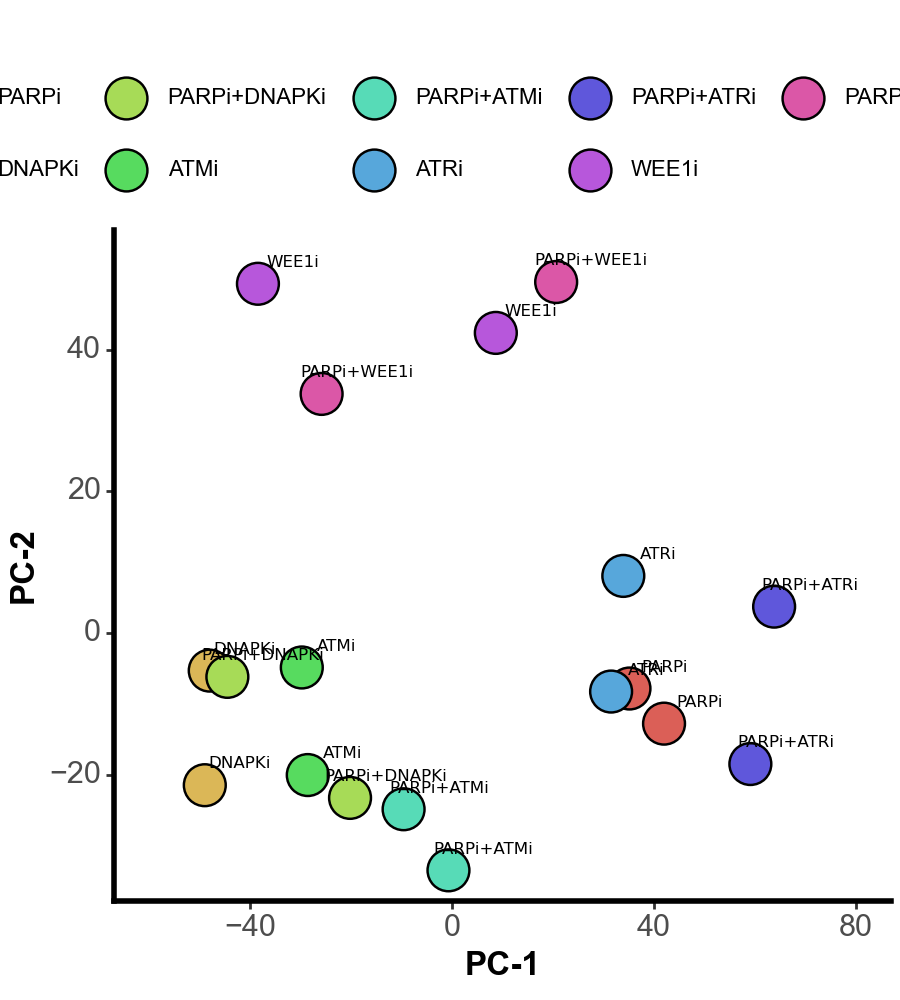

<Figure Size: (450 x 500)>

In [53]:
pca_p

In [54]:
pca_p.save('PCA_ggplot.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 5 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_ggplot.pdf


### CRISPRa A549

In [226]:
Ca_A549_pdata = get_pdata(Ca_A549)

Ca_A549_pdata = Ca_A549_pdata[~Ca_A549_pdata.obs.score.str.contains('tau')].copy()

In [227]:
Ca_A549_pdata.obs

,score,replicate
gamma Rep1,gamma,Rep1
PARPi Rep1,PARPi,Rep1
ATRi Rep1,ATRi,Rep1
WEE1i Rep1,WEE1i,Rep1
PARPi+ATRi Rep1,PARPi+ATRi,Rep1
PARPi+WEE1i Rep1,PARPi+WEE1i,Rep1


In [228]:
Ca_A549_pdata.obs.score = pd.Categorical(
    Ca_A549_pdata.obs.score,
    categories=['gamma',
                'PARPi',
                'ATRi',
                'PARPi+ATRi',
                'WEE1i',
                'PARPi+WEE1i'
               ]
)


Ca_A549_pdata.obs['treatment'] = 'ctrl'
Ca_A549_pdata.obs.loc[Ca_A549_pdata.obs.score.str.contains('i'),'treatment'] = 'mono'
Ca_A549_pdata.obs.loc[Ca_A549_pdata.obs.score.str.contains('i\+'),'treatment'] = 'combo'
Ca_A549_pdata.obs['treatment'] = pd.Categorical(Ca_A549_pdata.obs['treatment'],categories=['ctrl','mono','combo'])

#### 

In [232]:
Ca_A549_pdata0 = Ca_A549_pdata.copy()

#### PCA (1)

In [229]:
# sc.pp.regress_out(Ca_A549_pdata,'replicate')

In [168]:
sc.tl.pca(Ca_A549_pdata, svd_solver='arpack')

In [230]:
Ca_A549_pdata

AnnData object with n_obs × n_vars = 6 × 103839
    obs: 'score', 'replicate', 'treatment'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'

In [220]:
Ca_A549_pca = plot_ggplot_pca(Ca_A549_pdata,fill='score',legend_position='none', figure_size=(3,3)) \
 + ggtitle('PCA CRISPRa A549') + theme(plot_title= element_text(weight='bold', ha='center'))

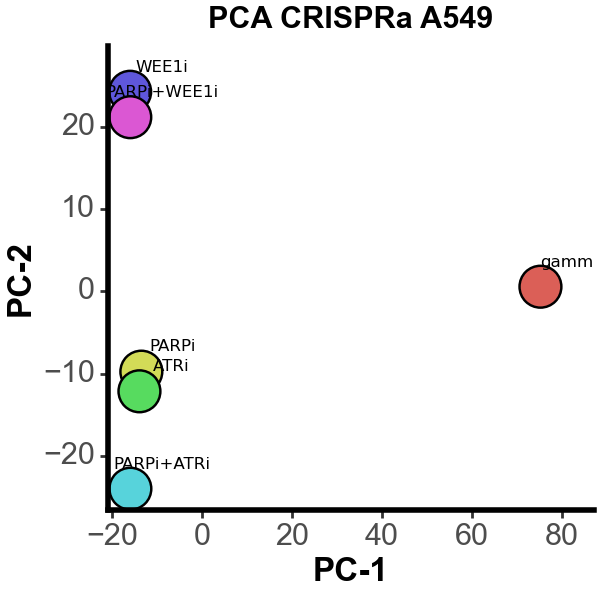

<Figure Size: (300 x 300)>

In [221]:
Ca_A549_pca

In [222]:
Ca_A549_pca.save('PCA_Ca_A549.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 3 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_Ca_A549.pdf


#### PCA (2)

In [240]:
Ca_A549_pdata_no_gamma = Ca_A549_pdata0[~Ca_A549_pdata0.obs.score.eq('gamma')].copy()

In [241]:
# sc.pp.regress_out(Ca_A549_pdata,'replicate')

In [242]:
sc.tl.pca(Ca_A549_pdata_no_gamma, svd_solver='arpack')

In [243]:
Ca_A549_pdata_no_gamma

AnnData object with n_obs × n_vars = 5 × 103839
    obs: 'score', 'replicate', 'treatment'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [244]:
Ca_A549_no_gamma_pca = plot_ggplot_pca(Ca_A549_pdata_no_gamma,fill='score',legend_position='none', figure_size=(3,3)) \
 + ggtitle('PCA CRISPRa A549') + theme(plot_title= element_text(weight='bold', ha='center'))

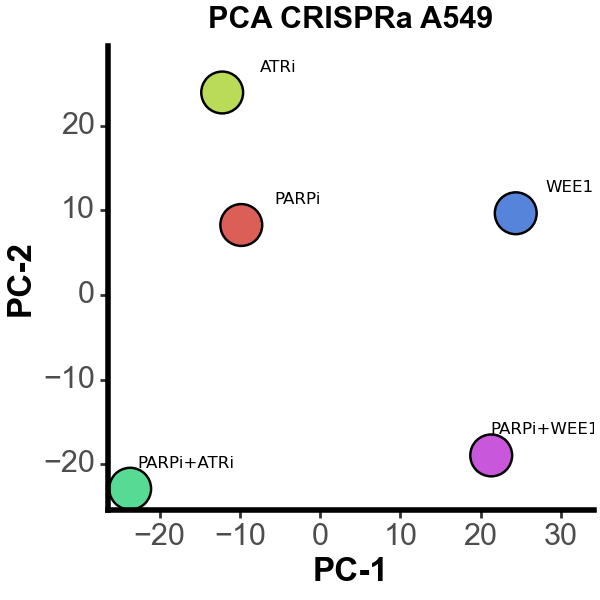

<Figure Size: (300 x 300)>

In [245]:
Ca_A549_no_gamma_pca

In [269]:
Ca_A549_no_gamma_pca.save('PCA_Ca_A549_no_gamma.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 3 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_Ca_A549_no_gamma.pdf


### CRISPRa k562

In [246]:
Ca_k562_pdata = get_pdata(Ca_k562)
Ca_k562_pdata = Ca_k562_pdata[~Ca_k562_pdata.obs.index.str.contains('ave'),].copy()

In [247]:
Ca_k562_pdata.obs.score = pd.Categorical(
    Ca_k562_pdata.obs.score,
    categories=['gamma',
                'PARPi',
                'PARPi+ATRi'
               ]
)


Ca_k562_pdata.obs['treatment'] = 'ctrl'
Ca_k562_pdata.obs.loc[Ca_k562_pdata.obs.score.str.contains('i'),'treatment'] = 'mono'
Ca_k562_pdata.obs.loc[Ca_k562_pdata.obs.score.str.contains('i\+'),'treatment'] = 'combo'
Ca_k562_pdata.obs['treatment'] = pd.Categorical(Ca_k562_pdata.obs['treatment'],categories=['ctrl','mono','combo'])

In [248]:
Ca_k562_pdata.obs

,score,replicate,treatment
gamma rep1,gamma,rep1,ctrl
gamma rep2,gamma,rep2,ctrl
PARPi rep1,PARPi,rep1,mono
PARPi rep2,PARPi,rep2,mono
PARPi+ATRi rep1,PARPi+ATRi,rep1,combo
PARPi+ATRi rep2,PARPi+ATRi,rep2,combo


#### 

In [249]:
Ca_k562_pdata0 = Ca_k562_pdata.copy()

#### PCA (1)

In [23]:
# sc.pp.regress_out(Ca_A549_pdata,'replicate')

In [214]:
sc.tl.pca(Ca_k562_pdata, svd_solver='arpack')

In [215]:
Ca_k562_pdata

AnnData object with n_obs × n_vars = 6 × 101437
    obs: 'score', 'replicate', 'treatment'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [223]:
Ca_k562_pca = plot_ggplot_pca(Ca_k562_pdata,fill='score',legend_position='none', figure_size=(3,3)) \
 + ggtitle('PCA CRISPRa k562') + theme(plot_title= element_text(weight='bold', ha='center'))

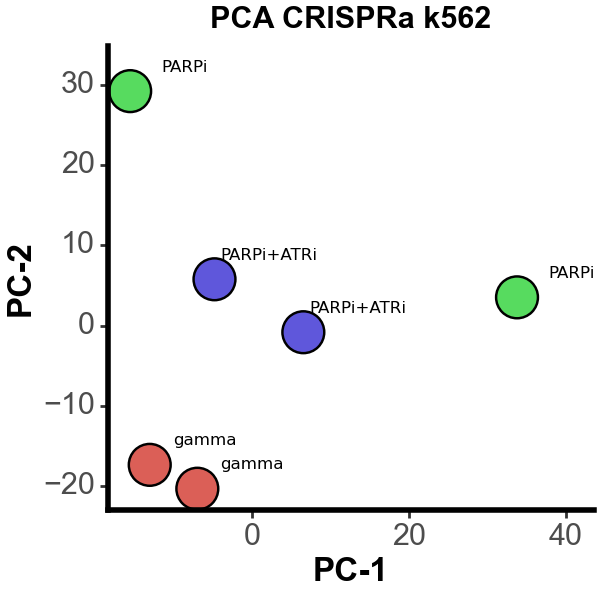

<Figure Size: (300 x 300)>

In [224]:
Ca_k562_pca

In [279]:
Ca_k562_pca.save('PCA_Ca_k562.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 3 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_Ca_k562.pdf


#### PCA (1)

In [272]:
Ca_k562_pdata_no_gamma = Ca_k562_pdata0[~Ca_k562_pdata0.obs.score.eq('gamma')].copy()

In [273]:
# sc.pp.regress_out(Ca_k562_pdata_no_gamma,'replicate')

In [274]:
sc.tl.pca(Ca_k562_pdata_no_gamma, svd_solver='arpack')

In [275]:
Ca_k562_pdata_no_gamma

AnnData object with n_obs × n_vars = 4 × 101437
    obs: 'score', 'replicate', 'treatment'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [276]:
Ca_k562_pca_no_gamma = plot_ggplot_pca(Ca_k562_pdata_no_gamma,fill='score',legend_position='none', figure_size=(3,3)) \
 + ggtitle('PCA CRISPRa k562') + theme(plot_title= element_text(weight='bold', ha='center'))

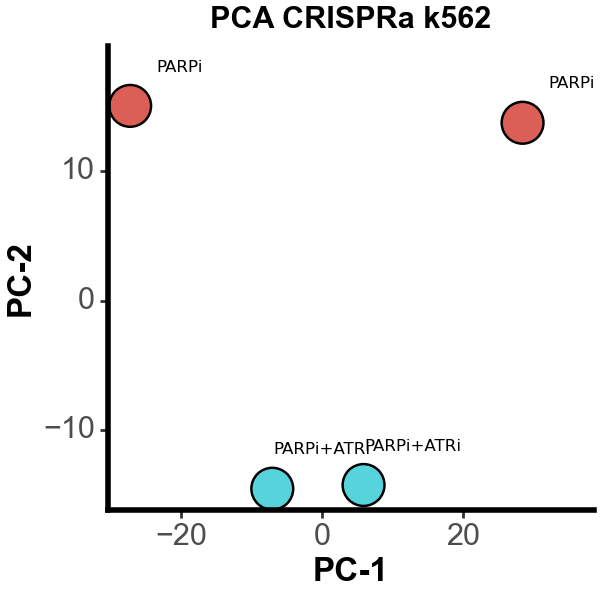

<Figure Size: (300 x 300)>

In [277]:
Ca_k562_pca_no_gamma

In [280]:
Ca_k562_pca_no_gamma.save('PCA_Ca_k562_no_gamma.pdf')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 3 in image.
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: PCA_Ca_k562_no_gamma.pdf


### Correlation plot

In [24]:
Ci_pdata_ave_rho = Ci_pdata_ave[~Ci_pdata_ave.obs.treatment.eq('ctrl')].copy()

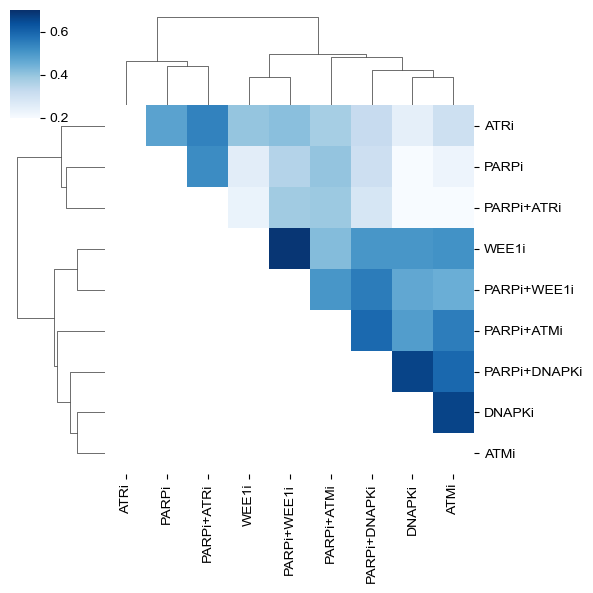

In [25]:
df = Ci_pdata_ave_rho.to_df().T
df.columns = df.columns.str.split(' ').str[0]

corr = df.corr()

g = sns.clustermap(corr, 
                   method = 'complete', 
                   # cmap   = 'rocket_r', 
                   cmap    = 'Blues', 
                   # annot   = True, 
                   vmin    = 0.2,
                   vmax    = 0.7,
                   annot_kws = {'size': 10},
                   figsize=(6, 6)
                  )
mask = np.tril(np.ones_like(corr))

values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90);

g.savefig("corr.pdf",transparent=True) 

## 

### gene corr!

___
    Mon Jul 17 17:32:12 PDT 2023

I need to fix this https://github.com/abearab/ScreenPro2/issues/9

In [85]:
def get_annotated_score_df(adata,score,level, rep_label='ave_rep1_rep2'):

    df = adata.phenotypes[level][score][rep_label][[
        'average phenotype of strongest 3',
        'Mann-Whitney p-value',
    ]].reset_index('gene').reset_index(drop=True).copy()
        
    df = scp.phenoScore.ann_score_df(df, ctrl_label='pseudo')
    
    return df

___

`Ci`

In [87]:
df = pd.concat(dict([
    (treat,get_annotated_score_df(Ci,score,'gene_scores').set_index('target'))
    for treat, score in Ci.comparisons.items()
]),axis=1)

In [88]:
df.to_csv('results/Ci_all_gene_scores_with_hit_labels.csv')

___

`Ca_A549`

In [103]:
df = pd.concat(dict([
    (treat,get_annotated_score_df(Ca_A549,score,'gene_scores',rep_label='Rep1').set_index('target'))
    for treat, score in Ca_A549.comparisons.items()
]),axis=1)

In [104]:
df.to_csv('results/Ca_A549_all_gene_scores_with_hit_labels.csv')

___

`Ca_A549`

In [105]:
df = pd.concat(dict([
    (treat,get_annotated_score_df(Ca_k562,score,'gene_scores').set_index('target'))
    for treat, score in Ca_k562.comparisons.items()
]),axis=1)

In [106]:
df.to_csv('results/Ca_k562_all_gene_scores_with_hit_labels.csv')

# 

In [281]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-10-26T17:09:11.568954-07:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
screenpro : 0.2.3
seaborn   : 0.12.2
scanpy    : 1.9.3
pandas    : 2.0.3
matplotlib: 3.7.2
anndata   : 0.9.1
numpy     : 1.24.4

